# Classification on Unseen Data (total 8 points)
In this final task, you should read the feather file 'TestQuestionsDF.feather.zstd' into a pandas dataframe. Hereafter this will be referred to as the test_set. <br>You can assume that the test_set is a random sample from the same dataset as 'TrainQuestionsDF.feather.zstd' (hereafter train_set).
Your goal is to classify the data in the test_set and achieve the best **average f1-score** using the train_set.
You are allowed to utilize any technique and model available in the scikit-learn library or the standard python libraries to do so.
Pay particular attention to the lessons learned from your experiments in the Classification notebook -- any of these approaches can be used to construct the model you use for prediction.
You can additionally choose to generate and/or construct any features from the available data. Remember that the test_set should be represented with the same feature space as the train_set. <br>For example, features based on text should be constructed with the same vocabulary on the test_set as the train_set.<br>
To achieve a high f1 score on unseen data, remember to utilize all the techniques you've learned in the lectures, lectorials and practicals.

For this task, you are expected to submit the following:
1. This notebook with your code, the code should be well documented and must run without errors.
    There is no time limit, but it is a good practice to save the parameters of the best model and add an option to generate a model with those parameters. Without running the full tuning of the hyper-parameters. <br>
2. Up to 4 prediction files, each predictions file will have exactly two columns: "Id" and "Label" with these headers and no other columns (e.g. index).<br>
 The file names should be SXXXXXXX-A2-predictions-\<n\>.csv - where n is a running integer {1,2,3,4}.

Your mark in this task will depend on the following:
1. The code is well documented, and the entire notebook runs without errors (1 points).
2. The submitted solutions are reproducible, i.e. the submitted code can generate the submitted prediction files (2 points).
3. The highest (out of the 4 prediction files) achieved average f1-score is in the following range:
 * (0.8, 1] (5 points)
 * (0.7, 0.8] (4 points)
 * (0.65, 0.7] (3 points)
 * (0, 0.65] (1 point)

To support the reproducibility of your solution, use the random seed anywhere where the solution involves a random process.

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# TODO: Any additional (if needed) import statements should be in this cell
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# TODO: Set the random seed as your student id (only numbers)
RANDOM_SEED = 3933758
np.random.seed(RANDOM_SEED)

In [4]:
def read_feather_to_df(feather_file_name):
    """
    The function expects to receive a path to feather file,
    it will read the file from the disk into a pandas dataframe
    """
    return pd.read_feather(feather_file_name)

In [5]:
train_df = read_feather_to_df('TrainQuestionsDF.feather.zstd')
test_df = read_feather_to_df('TestQuestionsDF.feather.zstd')
test_df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,AnswerCount,CommentCount,FavoriteCount,LastEditorDisplayName,LastEditDate,LastEditorUserId,CommunityOwnedDate,ParentId,ClosedDate,OwnerDisplayName
0,2,1,59,2010-07-19 19:12:57.157,31,30036,<p>In many different statistical methods there...,24,2017-11-22 12:15:07.030,What is normality?,7,1,11,user88,2010-08-07 17:56:44.800,-1,NaT,-1,NaT,NA
1,30,1,55,2010-07-19 19:28:34.220,13,1620,<p>Which methods are used for testing random v...,69,2011-05-12 18:38:27.547,Testing random variate generation algorithms,8,2,11,NA,2010-08-25 14:12:54.547,919,NaT,-1,NaT,NA
2,298,1,-1,2010-07-20 13:11:50.297,161,312967,<p>Am I looking for a better behaved distribut...,125,2016-09-21 15:41:29.603,"In linear regression, when is it appropriate t...",8,5,227,NA,2015-10-19 11:38:06.097,4253,NaT,-1,NaT,NA
3,870,1,956,2010-07-28 03:54:56.447,22,26750,<p>Given a list of p-values generated from ind...,520,2013-03-07 01:26:38.717,Multiple hypothesis testing correction with Be...,1,4,10,NA,2010-08-12 16:07:55.730,520,NaT,-1,NaT,NA
4,881,1,1189,2010-07-28 08:15:51.733,5,919,<p>Here's something I've wondered about for a ...,34,2011-03-28 08:58:47.087,Series expansion of a density function,3,0,2,user88,2011-03-28 08:58:47.087,-1,NaT,-1,NaT,NA


In [6]:
# TODO: Write your code below.
# You can split it into as many cells and functions as you see fit to make it readable and well documented.
# df = train_df.set_index('Id')
# X_train, X_test, y_train, y_test = train_test_split(df.ix[:, ~df.columns.isin(['Label'])], df.Response)
# print(X_train)

In [7]:
X = train_df.drop(columns=['Label'])
y = train_df.Label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

In [8]:
def select_numeric_non_id_columns(df):
    """
    Return a subset of a DataFrame’s columns based on the column dtypes,
    including only numerical columns and excluding columns with the string id (case-insensitive) in their name
    :param df: pd.DataFrame
    :return: pd.DataFrame
    """
    # TODO: write your code here
    df = df.select_dtypes(include=['Int64'])
    df = df.loc[:, ~df.columns.str.contains("Id")]
    return df


def fit_tree_classifier(X, y, **decisiontree_kwargs):
    """
    The function receives a multidimensional array or a dataframe of features as X and one dimensional array or pandas Series as y.
    It creates a DecisionTreeClassifier classifier with random_state=RANDOM_SEED, fits it on X and y and returns the fitted classifier.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param y: array-like; data class labels
    :param decisiontree_kwargs: key-word arguments that will be passed to DecisionTreeClassifier class
    :return: a fitted DecisionTreeClassifier object
    """
    # TODO: write your code here
    clf = DecisionTreeClassifier(**decisiontree_kwargs,random_state=RANDOM_SEED)
    clf = clf.fit(X,y)
    return clf


def fit_knn_classifier(X, y, **knn_kwargs):
    """
    The function receives a multidimensional array or a dataframe of features as X, on dimensional array or pandas Series as y.
    It creates a DecisionTreeClassifier classifier with random_state=RANDOM_SEED, fits it on X and y and returns the fitted classifier.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param y: array-like; data class labels
    :param knn_kwargs: key-word arguments that will be passed to KNeighborsClassifier class
    :return: a fitted KNeighborsClassifier object
    """
    # TODO: write your code here
    neigh = KNeighborsClassifier(**knn_kwargs)
    neigh = neigh.fit(X,y)
    return neigh

def evaluate_classification(y_true, y_predicted):
    """
    The function receives two arrays or pandas Series with the same length, the actual labels and the predicted labels.
    It then prints the sklearn classification_report and plots a confusion matrix as a heatmap using the class ConfusionMatrixDisplay.
    The plot should be readable (e.g. not overlapping labels or too small text)
    :param y_true: array-like; ground truth data class labels
    :param y_predicted: array-like; predicted data class labels
    """
    # TODO: write your code here
    print(classification_report(y_true, y_predicted))
    mat=ConfusionMatrixDisplay.from_predictions(y_true, y_predicted, xticks_rotation=40)
    return

def series_to_tfidf(sr, **tfidfvectorizer_kwargs):
    """
    The function receives an array or a pandas Series that contains text strings (a.k.a documents).
    It then converts the documents into a matrix of TF-IDF features
    The function should return two objects:
    TfidfVectorizer object after it learned (fitted) the vocabulary and idf from the training set,
    and a document-term matrix (the original documents array transformed into a TF-IDF features matrix).
    :param sr: pd.Series, contains text strings
    :param tfidfvectorizer_kwargs: key-word arguments that will be passed to TfidfVectorizer class
    :return: two objects, the fitted TfidfVectorizer object and the tf-idf document-term sparse matrix
    """
    # TODO: write your code here
    vectorizer = TfidfVectorizer(**tfidfvectorizer_kwargs)#max_features=100,
                                #max_df=0.8,
                                #min_df=5,
                                #stop_words='english'
    vectors = vectorizer.fit_transform(sr)
    return vectorizer, vectors

In [9]:
##text feature extraction with classifiers 
#Random Forest with tfidf, looking for best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',RandomForestClassifier())])

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df':np.arange(5,10,1),
    'clf__max_depth': np.arange(1,10,1),
    'tfidf__stop_words':['english'],
    'clf__random_state':[RANDOM_SEED],
    'clf__n_estimators':[50,100] 
    #'clf__min_samples_split': np.arange(1,4,1),
    #'tfidf__use_idf': (True, False) #means we score only with TF not IDF to-interesting this improved performance
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=3)
grid_search_tune.fit(X_train.Title, y_train)
print("Best Tree TF-IDF score and parameters:")
print(grid_search_tune.best_score_)
print(grid_search_tune.best_params_)

Fitting 2 folds for each of 270 candidates, totalling 540 fits
Best Tree TF-IDF score and parameters:
0.6236832085290012
{'clf__max_depth': 9, 'clf__n_estimators': 100, 'clf__random_state': 3933758, 'tfidf__max_df': 0.25, 'tfidf__min_df': 5, 'tfidf__stop_words': 'english'}


                    precision    recall  f1-score   support

          bayesian       0.87      0.75      0.81       751
     distributions       0.64      0.65      0.65       750
hypothesis-testing       0.70      0.77      0.74       751
          logistic       0.82      0.81      0.82       750
       probability       0.59      0.62      0.60       751
        self-study       0.47      0.47      0.47       750
       time-series       0.80      0.76      0.78       750

          accuracy                           0.69      5253
         macro avg       0.70      0.69      0.69      5253
      weighted avg       0.70      0.69      0.69      5253



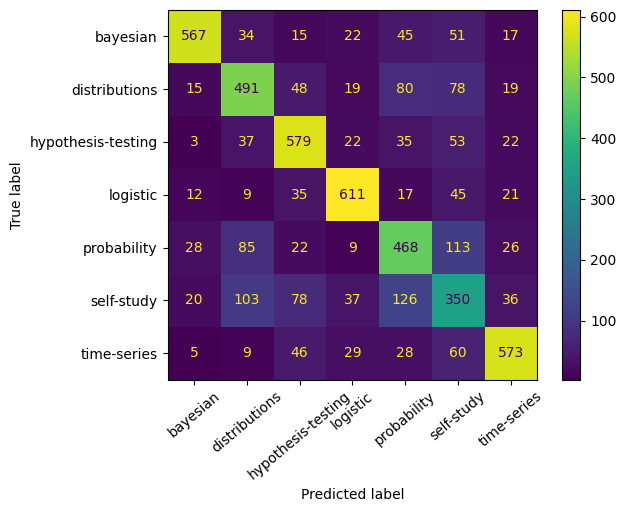

In [10]:
#tf-idf vectorizer
TFIDF_train_vect= series_to_tfidf(X_train.Title,max_df=0.25, min_df=5,use_idf=False,stop_words='english')
tfidf_test_vect= TFIDF_train_vect[0].transform(X_test['Title'])
#classifier
classifier=RandomForestClassifier(random_state=RANDOM_SEED)
classifier.fit(TFIDF_train_vect[1],y_train)
y_pred_fores= classifier.predict(tfidf_test_vect)
evaluate_classification(y_test, y_pred_fores)
#yielded best results of all attempts by using random forest classifier

In [11]:
#use random forest tf-idf to make prediction file for test_df
test_df_pred=test_df
test_df_pred=TFIDF_train_vect[0].transform(test_df_pred.Title)
pred = classifier.predict(test_df_pred)
pred_df= pd.DataFrame(pred)
test_df['Label']=pred
forest_pred= test_df[['Id', 'Label']]
forest_pred
#to csv
forest_pred.to_csv('S3933758-A2-predictions-1.csv')

####Done#### other methods below did not seem to get as high accuracy results 
#and because of limited time I have only submitted the above csv file for marking

In [12]:
#KNN with tfidf prev accuracy = 0.56
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('clf', KNeighborsClassifier())])

# parameters = {
#     #'tfidf__max_df': (0.25, 0.5, 0.75),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__min_df': (5, 20, 25),
#     'clf__n_neighbors': np.arange(1,50,10),
#     'tfidf__stop_words':['english'],
# }

# grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=3)
# grid_search_tune.fit(X_train.Title, y_train)
# print("Best KNN TF-IDF score and parameters:")
# print(grid_search_tune.best_score_)
# print(grid_search_tune.best_params_)
# # 0.62-0.56 = 0.6 or 6% improvement

In [13]:
#tf-idf vector
# TFIDF_train_vect_KNN= series_to_tfidf(X_train.Title,max_df=0.25,gram_range=(1, 3) min_df=10,stop_words='english')#
# tfidf_test_vect_KNN= TFIDF_train_vect_KNN[0].transform(X_test['Title'])

# #KNN classifier with tf-idf
# knn_tfidf= fit_knn_classifier(TFIDF_train_vect_KNN[1],y_train,n_neighbours=40)
# y_pred_tfidf_KNN= knn_tfidf.predict(tfidf_test_vect_KNN)
# evaluate_classification(y_test, y_pred_tfidf_KNN)

# #classifier
# KNN=KNeighborsClassifier(n_neighbors=39)
# KNN.fit(TFIDF_train_vect[1],y_train)
# y_pred_KNN= KNN.predict(tfidf_test_vect)
# evaluate_classification(y_test, y_pred_KNN)

#use Knn tf-idf to make prediction file for test_df
# test_df_pred=test_df.Title
# test_df_pred=TFIDF_train_vect.transform(test_df_pred)
# KNN_prediction = knn_tfidf.predict(test_df_pred)
# KNN_prediction
# KNN_prediction= pd.DataFrame(forest_prediction)
# KNN_prediction

[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=8, tfidf__stop_words=english;, score=0.494 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=7, tfidf__stop_words=english;, score=0.517 total time=   0.5s
[CV 1/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.75, tfidf__min_df=6, tfidf__stop_words=english;, score=0.528 total time=   0.5s
[CV 1/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__stop_words=english;, score=0.599 total time=   0.7s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=9, tfidf__stop_words=english;, score=0.581 total time=   0.7s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=8, tf

[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=7, tfidf__stop_words=english;, score=0.517 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=6, tfidf__stop_words=english;, score=0.449 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__stop_words=english;, score=0.576 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.75, tfidf__min_df=9, tfidf__stop_words=english;, score=0.565 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=8, tfidf__stop_words=english;, score=0.567 total time=   0.7s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=7, tfi

[CV 1/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=7, tfidf__stop_words=english;, score=0.520 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__stop_words=english;, score=0.576 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=9, tfidf__stop_words=english;, score=0.565 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.75, tfidf__min_df=8, tfidf__stop_words=english;, score=0.494 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=7, tfidf__stop_words=english;, score=0.582 total time=   0.7s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=6, tfid

[CV 1/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__stop_words=english;, score=0.539 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=9, tfidf__stop_words=english;, score=0.565 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=8, tfidf__stop_words=english;, score=0.494 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=50, clf__random_state=3933758, tfidf__max_df=0.75, tfidf__min_df=7, tfidf__stop_words=english;, score=0.517 total time=   0.5s
[CV 2/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.25, tfidf__min_df=6, tfidf__stop_words=english;, score=0.552 total time=   0.7s
[CV 1/2] END clf__max_depth=1, clf__n_estimators=100, clf__random_state=3933758, tfidf__max_df=0.5, tfidf__min_df=6, tfi